In [1]:
import numpy as np
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt


db_name = "GeSiNW_Qubit_VTI01_Jonas (4).db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path

initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

plt.style.use('dark_background')

# High Resolution Data

In [2]:
Negatives = [[97,98], [99,100], [101,102], [103,104], [105,106], [107,108], [109,110], [111,112], [117,118], [119,120], [122,123], [124,125],
[127,128], [130,131], [1099,1100],[1102,1103],[1133,1134],[1135,1136],[1138,1139],[1142,1143],[1144,1145],[1146,1147],[1149,1150],[1152,1153],
[1155,1156],[1166,1167],[1074,1075],[1077,1078],[1080,1081],[1043,1044],[1048,1049],[1018,1019]]


Positives = [[113,114], [115,116],
             [1189, 1190],[1119,1120],[1122,1123],[1083,1084],[1045,1046],[1020,1021],[1023,1024]
]


invert = [[1142, 1143],[1144, 1145],[1146, 1147],[1149, 1150],[1152, 1153],[1155, 1156],[1166, 1167],[1074, 1075] ,[1077, 1078], [1080, 1081], [1189, 1190], [1083, 1084]]


neg_high_res_blocked = []
neg_high_res_unblocked = []

for pair in Negatives:

    blocked = -load_by_run_spec(captured_run_id = pair[0] ).to_xarray_dataset()['I_SD'].to_numpy()
    unblocked = -load_by_run_spec(captured_run_id= pair[1]).to_xarray_dataset()['I_SD'].to_numpy()

    if pair in invert:
        blocked = -blocked.T
        unblocked = -unblocked.T

    neg_high_res_blocked.append(blocked)
    neg_high_res_unblocked.append(unblocked)


pos_high_res_blocked = []
pos_high_res_unblocked = []

for pair in Positives:

    blocked = -load_by_run_spec(captured_run_id = pair[0] ).to_xarray_dataset()['I_SD'].to_numpy()
    unblocked = -load_by_run_spec(captured_run_id= pair[1]).to_xarray_dataset()['I_SD'].to_numpy()
    if pair in invert:
        blocked = -blocked.T
        unblocked = -unblocked.T

    pos_high_res_blocked.append(blocked)
    pos_high_res_unblocked.append(unblocked)



high_res_blocked = neg_high_res_blocked + pos_high_res_blocked
high_res_unblocked = neg_high_res_unblocked + pos_high_res_unblocked

#Labels
labels = np.zeros(len(high_res_blocked))
t = len(pos_high_res_blocked)
labels[-t:] = 1

# PSB-Detection (New)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

from alt_PSB_detection import PSB_detector_new
import btriangle_detection, btriangle_properties
from btriangle_properties import detect_base_alt, detect_base_alt_slope
from btriangle_detection import PSB_detector
import cv2 as cv

PSB_List = []
intensity_pairs = []
intensity_diff = []


for j in range(len(high_res_blocked)):
    
    res_h = 2
    min_area_h = (high_res_unblocked[j].shape[0]*high_res_unblocked[j].shape[1]*res_h*res_h)*0.01
    
    unblocked, ims, masks = btriangle_detection.triangle_segmentation_alg(high_res_unblocked[j],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
    base, corner_pts, c_im = detect_base_alt_slope(unblocked, masks, 'down')
    
    
    
    min_area_h = (high_res_blocked[j].shape[0]*high_res_blocked[j].shape[1]*res_h*res_h)*0.01
    
    blocked,ims2, masks2 = btriangle_detection.triangle_segmentation_alg(high_res_blocked[j],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True,allow_MET = False, direction = 'down')
    
    pair, PSB = PSB_detector_new(unblocked, blocked, base, masks, 'down', slope_tol = 0.4, int_tol = 0.05, median = False, seg_tol = 0.05)  
    intensity_pairs.append(pair)
    
    PSB_List.append(int(PSB))
    
    if len(pair)>0:
        intensity_diff.append(abs(pair[0]-pair[1]))
    else:
        intensity_diff.append(0)
        
    
PSB_N = np.array(PSB_List)    
acc = accuracy_score(labels, PSB_N)


print('The PSB detector is ',round(acc*100,2),'% accurate in',round(len(PSB_N)/len(labels)*100,2),'% of the data, with recall ',round(recall_score(labels, PSB_N)*100,2),'% and precision ', round(precision_score(labels, PSB_N)*100,2),'%.')  

Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
The PSB detector is  75.61 % accurate in 100.0 % of the data, with recall  88.89 % and precision  47.06 %.


/Users/madeleine/Downloads/btriangle_properties.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels,PSB_N)

array([[23,  9],
       [ 1,  8]])

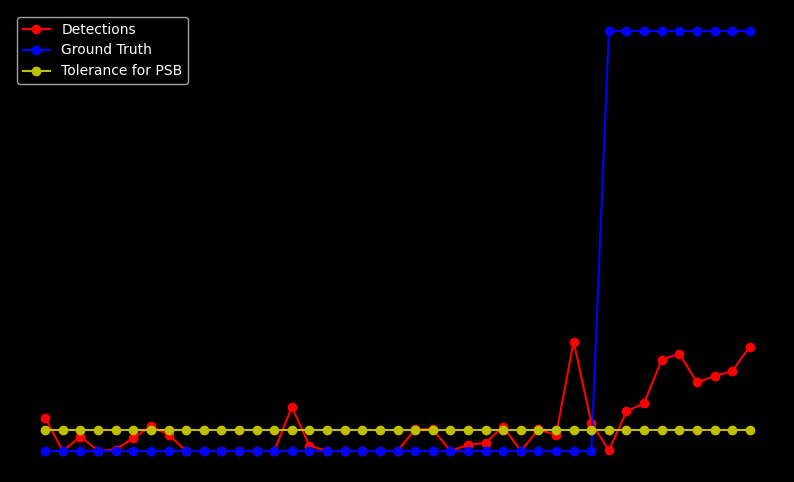

In [9]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(PSB_N)),np.array(intensity_diff),'-or')
plt.plot(np.arange(0,len(PSB_N)),labels.tolist(),'-ob')
plt.plot(np.arange(0,len(PSB_N)),np.ones(len(labels))*0.05,'-oy')
plt.axis('off')
plt.legend(['Detections', 'Ground Truth', 'Tolerance for PSB'])
plt.show()

# PSB-Detection (Old)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

from alt_PSB_detection import PSB_detector_new
import btriangle_detection, btriangle_properties
from btriangle_properties import detect_base_alt, detect_base_alt_slope
from btriangle_detection import PSB_detector
import cv2 as cv

PSB_List = []
intensity_pairs = []
intensity_diff = []


for j in range(len(high_res_blocked)):
    
    res_h = 2
    min_area_h = (high_res_unblocked[j].shape[0]*high_res_unblocked[j].shape[1]*res_h*res_h)*0.01
    
    unblocked, ims, masks = btriangle_detection.triangle_segmentation_alg(high_res_unblocked[j],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
    base, corner_pts, c_im = detect_base_alt(unblocked, masks, 'down')
    
    
    
    min_area_h = (high_res_blocked[j].shape[0]*high_res_blocked[j].shape[1]*res_h*res_h)*0.01
    
    blocked,ims2, masks2 = btriangle_detection.triangle_segmentation_alg(high_res_blocked[j],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True,allow_MET = False, direction = 'down')
    
    pair, PSB = PSB_detector(unblocked, blocked, base, masks, 'down', slope_tol = 0.4, int_tol = 0.05, median = False)#, seg_tol = 0.05)  
    intensity_pairs.append(pair)
    
    PSB_List.append(int(PSB))
    
    if len(pair)>0:
        intensity_diff.append(abs(pair[0]-pair[1]))
    else:
        intensity_diff.append(0)
        
    
PSB_N = np.array(PSB_List)    
acc = accuracy_score(labels, PSB_N)


print('The PSB detector is ',round(acc*100,2),'% accurate in',round(len(PSB_N)/len(labels)*100,2),'% of the data, with recall ',round(recall_score(labels, PSB_N)*100,2),'% and precision ', round(precision_score(labels, PSB_N)*100,2),'%.') 

No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
The PSB detector is  63.41 % accurate in 100.0 % of the data, with recall  77.78 % and precision  35.0 %.


/Users/madeleine/Downloads/btriangle_properties.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels,PSB_N)

array([[19, 13],
       [ 2,  7]])

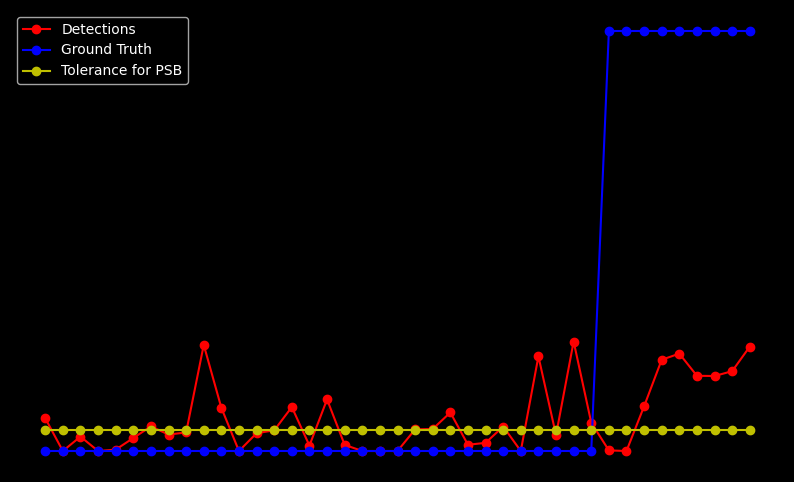

In [12]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(PSB_N)),np.array(intensity_diff),'-or')
plt.plot(np.arange(0,len(PSB_N)),labels.tolist(),'-ob')
plt.plot(np.arange(0,len(PSB_N)),np.ones(len(labels))*0.05,'-oy')
plt.axis('off')
plt.legend(['Detections', 'Ground Truth', 'Tolerance for PSB'])
plt.show()

# Low-Res Data

In [13]:
imgs = np.load('all_cutouts_collected.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

# PSB-Detection (New)

In [14]:
import btriangle_detection, btriangle_properties
from btriangle_properties import detect_base_alt, detect_base
PSB_List = []
intensity_pairs = []
intensity_diff = []
centers = []

for j in range(len(imgs)):
    
    res_h = 2
    min_area_h = (imgs[j][1].shape[0]*imgs[j][1].shape[1]*res_h*res_h)*0.01
    
    unblocked, ims, masks = btriangle_detection.triangle_segmentation_alg(imgs[j][1],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = False, allow_MET = False, direction = 'down')
    base, corner_pts, c_im = detect_base_alt_slope(unblocked, masks, 'down')
    
    
    
    min_area_h = (imgs[j][0].shape[0]*imgs[j][0].shape[1]*res_h*res_h)*0.01
    
    blocked,ims2, masks2 = btriangle_detection.triangle_segmentation_alg(imgs[j][0],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = False,allow_MET = False, direction = 'down')
    
    pair, PSB = PSB_detector_new(unblocked, blocked, base, masks, 'down', slope_tol = 0.4, int_tol = 0.05, median = False, seg_tol = 0.01)  
    intensity_pairs.append(pair)
    
    PSB_List.append(int(PSB))
    
    if len(pair)>0:
        intensity_diff.append(abs(pair[0]-pair[1]))
    else:
        intensity_diff.append(0)
        
    
PSB_N = np.array(PSB_List)    
acc = accuracy_score(labels, PSB_N)


print('The PSB detector is ',round(acc*100,2),'% accurate in',round(len(PSB_N)/len(labels)*100,2),'% of the data, with recall ',round(recall_score(labels, PSB_N)*100,2),'% and precision ', round(precision_score(labels, PSB_N)*100,2),'%.') 

/Users/madeleine/Downloads/btriangle_properties.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
No proper baseline slope detected, segmentation may have failed.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too sm

In [15]:
confusion_matrix(labels,PSB_N)

array([[185,  66],
       [  4,  18]])

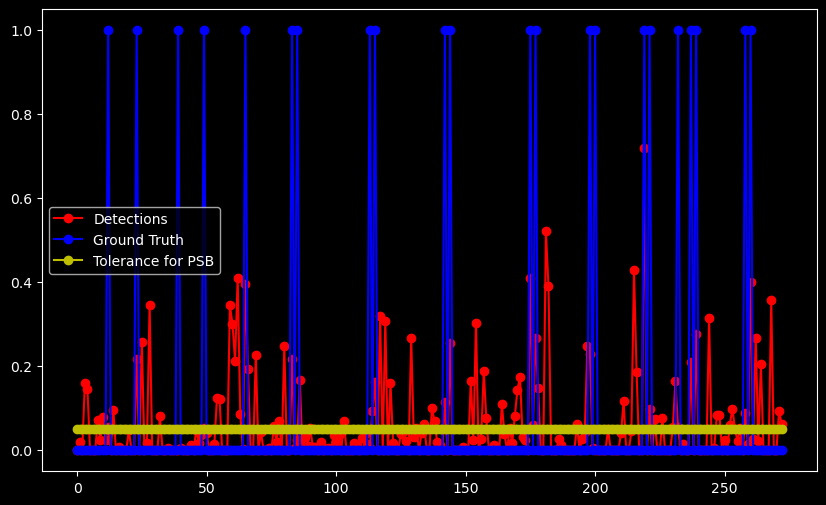

In [16]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(PSB_N)),np.array(intensity_diff),'-or')
plt.plot(np.arange(0,len(PSB_N)),labels.tolist(),'-ob')
plt.plot(np.arange(0,len(PSB_N)),np.ones(len(PSB_N))*0.05,'-oy')
#plt.axis('off')
plt.legend(['Detections', 'Ground Truth', 'Tolerance for PSB'])
plt.show()

# PSB-Detections (Old)

In [17]:
PSB_List = []
intensity_pairs = []
intensity_diff = []
centers = []

for j in range(len(imgs)):
    
    res_h = 2
    min_area_h = (imgs[j][1].shape[0]*imgs[j][1].shape[1]*res_h*res_h)*0.01
    
    unblocked, ims, masks = btriangle_detection.triangle_segmentation_alg(imgs[j][1],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = False, allow_MET = False, direction = 'down')
    base, corner_pts, c_im = detect_base_alt(unblocked, masks, 'down')
    
    min_area_h = (imgs[j][0].shape[0]*imgs[j][0].shape[1]*res_h*res_h)*0.01
    
    blocked,ims2, masks2 = btriangle_detection.triangle_segmentation_alg(imgs[j][0],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = False,allow_MET = False, direction = 'down')
    
    pair, PSB = PSB_detector(unblocked, blocked, base, masks, 'down', slope_tol = 0.4, int_tol = 0.05, median = False, seg_tol = 0.01)  
    intensity_pairs.append(pair)
    
    PSB_List.append(int(PSB))
    
    if len(pair)>0:
        intensity_diff.append(abs(pair[0]-pair[1]))
    else:
        intensity_diff.append(0)
        
    
PSB_N = np.array(PSB_List)    
acc = accuracy_score(labels, PSB_N)


print('The PSB detector is ',round(acc*100,2),'% accurate in',round(len(PSB_N)/len(labels)*100,2),'% of the data, with recall ',round(recall_score(labels, PSB_N)*100,2),'% and precision ', round(precision_score(labels, PSB_N)*100,2),'%.')

/Users/madeleine/Downloads/btriangle_properties.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
No lines found
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
Segment too small, no PSB.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
Segment too small, no PSB.
No lines found, potentially increase tolerance for slope deviation.
Segment too small, no PSB.
Segment too small, no PSB.
No lines

In [18]:
confusion_matrix(labels,PSB_N)

array([[198,  53],
       [  5,  17]])

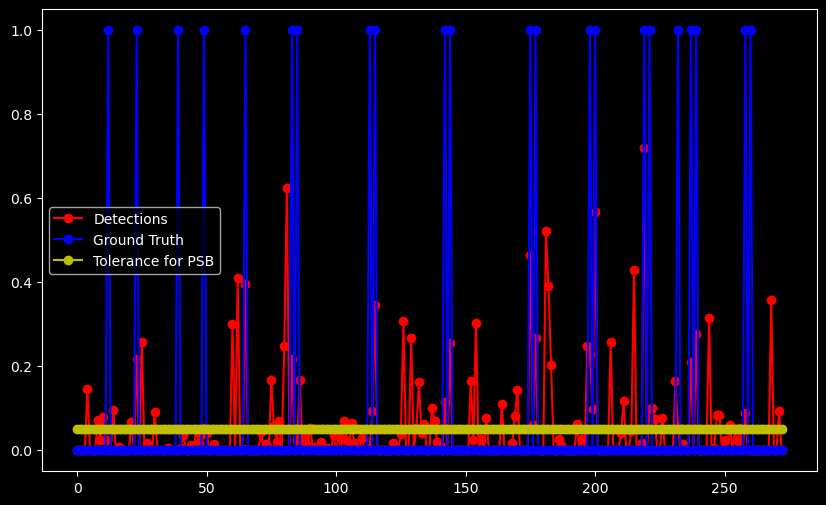

In [19]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(PSB_N)),np.array(intensity_diff),'-or')
plt.plot(np.arange(0,len(PSB_N)),labels.tolist(),'-ob')
plt.plot(np.arange(0,len(PSB_N)),np.ones(len(PSB_N))*0.05,'-oy')
#plt.axis('off')
plt.legend(['Detections', 'Ground Truth', 'Tolerance for PSB'])
plt.show()